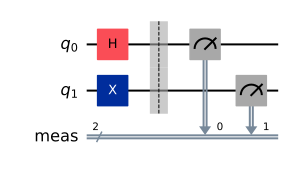

In [236]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import pyzx as zx
import numpy as np
pi = np.pi

qc = QuantumCircuit(2)

# qc.u(pi,pi,pi/2,0)
qc.h(0)
qc.x(1)
qc.measure_all()
qc.draw("mpl")



In [237]:
#generate pass manager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

Transpiling circuit and converting into qasm2 strings

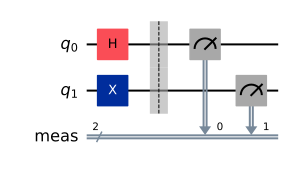

In [239]:
trans = transpile(qc, optimization_level=2)
trans.draw("mpl", idle_wires=False)

In [240]:
import qiskit.qasm2
q3 = qiskit.qasm2.dumps(trans)

print(q3)
circ = zx.qasm(q3)
zx.draw(circ)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg meas[2];
h q[0];
x q[1];
barrier q[0],q[1];
measure q[0] -> meas[0];
measure q[1] -> meas[1];


## Smallest Circuit that fails with Verify_equality()

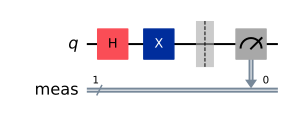

In [241]:
# Circuit
qc2 = QuantumCircuit(1)
# qc2.x(0)
qc2.h(0)
qc2.x(0)
qc2.measure_all()
qc2.draw("mpl")

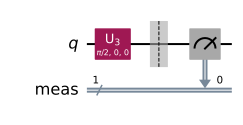

In [242]:
trans0 = transpile(qc2, optimization_level=0)
trans0.draw("mpl", idle_wires=False)

trans1 = transpile(qc2, optimization_level=1)
trans1.draw("mpl", idle_wires=False)

trans2 = transpile(qc2, optimization_level=2)
trans2.draw("mpl", idle_wires=False)

trans3 = transpile(qc2, optimization_level=3)
trans3.draw("mpl", idle_wires=False)

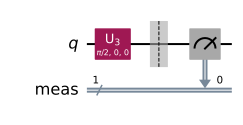

In [243]:
trans1.draw("mpl", idle_wires=False)

In [244]:
q2 = qiskit.qasm2.dumps(trans2)
q0 = qiskit.qasm2.dumps(trans0)
q3 = qiskit.qasm2.dumps(trans3)
q1 = qiskit.qasm2.dumps(trans1)

print(q2)
circ2 = zx.qasm(q2)
circ0 = zx.qasm(q0)
circ1 = zx.qasm(q1)
circ3 = zx.qasm(q3)

zx.draw(circ0)
zx.draw(circ1)
zx.draw(circ2)
zx.draw(circ3)


OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg meas[1];
u3(pi/2,0,0) q[0];
barrier q[0];
measure q[0] -> meas[0];


Checking for false instances

In [245]:
circ0.verify_equality(circ1)

True

In [246]:
circ1.verify_equality(circ2)

False

In [247]:
circ2.verify_equality(circ2)

False

In [248]:
circ2.verify_equality(circ3)

False

In [249]:
circ1.verify_equality(circ1)

False

In [250]:
circ0.verify_equality(circ0)

True

In [251]:
circ3.verify_equality(circ3, up_to_swaps=True)

False

In [252]:
# fully reducing the circuits before verifying equality

c1 = circ1.to_graph()
zx.full_reduce(c1)

c0 = circ0.to_graph()
zx.full_reduce(c0)

c2 = circ2.to_graph()
zx.full_reduce(c2)

c3 = circ3.to_graph()
zx.full_reduce(c3)


In [253]:
zx.draw(c0)
zx.draw(c1)
zx.draw(c2)
zx.draw(c3)

In [254]:
# extrating circuit from zx graph
c0_opt = zx.Circuit.from_graph(c0)
c1_opt = zx.Circuit.from_graph(c1)
c2_opt = zx.Circuit.from_graph(c2)
c3_opt = zx.Circuit.from_graph(c3)

In [255]:
c2_opt.verify_equality(c2_opt)

True

In [256]:
# observing the default verify_equality() method by printing the veritices
zx.draw(circ2)
c2 = circ2.to_graph()
zx.full_reduce(c2)
c2_opt = zx.Circuit.from_graph(c2)
c = c2_opt.adjoint()
c.add_circuit(c2_opt)
zx.draw(c)

g = c.to_graph()
print("before:",g.num_vertices(), c2_opt.qubits*2)
zx.full_reduce(g)
zx.draw(g)

print("after:",g.num_vertices(), c2_opt.qubits*2)
print(all(g.edge_type(e) == 1 for e in g.edges()))
if (all(g.edge_type(e) == 1 for e in g.edges())):
    print("hi")
    print(all(g.connected(v,w) for v,w in zip(g.inputs(),g.outputs())))
    
#     else:
#         return all(g.connected(v,w) for v,w in zip(g.inputs(),g.o/utputs()))
# else:
#     return False

before: 6 2


after: 2 2
True
hi
True


### Custom Verify Equality ###

Method 1 - By Fully reducing the circuits - it works for all instances 


Method 2 - Without fully reducing the circuits initially, extract_circuit() effects the combined graph directly which uses more optimized way to extract the circuit.

In [278]:
def verify_eq(self, other, up_to_swaps=False):
    ### First method - By Fully reducing the circuits - it works for all instances ###
    s = self.to_graph()
    # zx.full_reduce(s)
    # # s.normalize()
    # s_opt = zx.extract_circuit(s)

    o = other.to_graph()
    # zx.full_reduce(o)
    # # o.normalize()
    # other_opt = zx.extract_circuit(o)


    ### Method 2 - Without fully reducing, extract_circuit() effects the combined graph directly which uses more optimized way to extract the circuit. 
    
    if self.bits or other.bits:
        # TODO once full_gnd_reduce is merged
        raise NotImplementedError("The equality verification does not support hybrid circuits.")

    c = self.adjoint()
    c.add_circuit(other)
    g = c.to_graph()
    zx.full_reduce(g) # full_reduce is necessary because without that it returns true in all instances even when it is supposed to be false.
    
    cc = zx.extract_circuit(g) # solved the problem of comparing different optimizaton leveled circuits without initially fully reducing the circuits.

    zx.draw(cc)
    print(g.edges())
    print(g.edge_type(e) for e in g.edges())
    print("g vertices:", g.num_vertices())
    print("self.qubits*2:", self.qubits*2)
    
    if (g.num_vertices() == self.qubits*2 and
                all(g.edge_type(e) == 1 for e in g.edges())):
        print("HI") # checks if the code enters the "if" stmnt
        if up_to_swaps:
            return True
        else:
            print("Else is here") # checks if the code enters the "else" stmnt
            
            ## Understanding the connectivity of the graph

            # Checking ISOMORPHISM
            # sConnLst = []
            # sNotConn = []

            # oConnLst = []
            # oNotConn = []
            # for v,w in zip(s.inputs(),s.outputs()):
            #     if s.connected(v,w) == True:
            #         sConnLst.append([v,w])
            #     else:
            #         sNotConn.append([v,w])
            #         # print(s.graph[v], w)
            #         # print(s.graph[v].keys())
            #         # print(s.connected(v,w))
            #         # print(v,w)
            #         # print()
            # for v,w in zip(o.inputs(),o.outputs()):
            #     if o.connected(v,w) == True:
            #         oConnLst.append([v,w])
            #     else:
            #         oNotConn.append([v,w])
            
            # print("S connected:", sConnLst, "\nS not connected:", sNotConn)
            # print("O connected:", oConnLst, "\nO not connected:", oNotConn)
            # return (sConnLst == oConnLst) and (sNotConn == oNotConn) ## Checks if the inidividual graphs of initial circuits have same connectivity.

            return all(g.connected(v,w) for v,w in zip(g.inputs(),g.outputs())) # -- initial else statement --
        
    else:
        return False

In [276]:
verify_eq(circ2,circ1) # checking if the previous false instances works

<generator object GraphS.edges at 0x000001D195E63D80>
<generator object verify_eq.<locals>.<genexpr> at 0x000001D195E62EA0>
g vertices: 2
self.qubits*2: 2
HI
Else is here


True

## Testing with 27 Qubit - QFT

In [269]:
qftOrig = zx.Circuit.load('.\qft\qft_indep_qiskit_27.qasm')
# zx.draw(qftOrig)
qft0 = zx.Circuit.load('.\second\qft_nativegates_ibm_qiskit_opt0_27.qasm')
# zx.draw(qft0)
qft1 = zx.Circuit.load('.\second\qft_nativegates_ibm_qiskit_opt1_27.qasm')
# zx.draw(qft1)
qft2 = zx.Circuit.load('.\second\qft_nativegates_ibm_qiskit_opt2_27.qasm')
zx.draw(qft2)
qft3 = zx.Circuit.load('.\second\qft_nativegates_ibm_qiskit_opt3_27.qasm')
# zx.draw(qft3)

# GHZ state circuit
circOther = zx.Circuit.load('.\ghz_new\ghz_nativegates_ibm_qiskit_opt3_27.qasm')


# zx.draw(circOther)
# c1 = qft1.to_graph()
# zx.full_reduce(c1)

# c0 = qft0.to_graph()
# zx.full_reduce(c0)

# c2 = qft2.to_graph()
# zx.full_reduce(c2)

# c3 = qft3.to_graph()
# zx.full_reduce(c3)


# c0_opt = zx.extract_circuit(c0)
# c1_opt = zx.extract_circuit(c1)
# c2_opt = zx.extract_circuit(c2)
# c3_opt = zx.extract_circuit(c3)

<>:1: SyntaxWarning: invalid escape sequence '\q'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\q'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\g'
C:\Users\siria\AppData\Local\Temp\ipykernel_28828\2741488604.py:1: SyntaxWarning: invalid escape sequence '\q'
  qftOrig = zx.Circuit.load('.\qft\qft_indep_qiskit_27.qasm')
C:\Users\siria\AppData\Local\Temp\ipykernel_28828\2741488604.py:3: SyntaxWarning: invalid escape sequence '\s'
  qft0 = zx.Circuit.load('.\second\qft_nativegates_ibm_qiskit_opt0_27.qasm')
C:\Users\siria\AppData\Local\Temp\ipy

In [279]:
verify_eq(qft2, qft1) # checking QFT circuits of different optimization levels

<generator object GraphS.edges at 0x000001D19331BA00>
<generator object verify_eq.<locals>.<genexpr> at 0x000001D19331B5A0>
g vertices: 54
self.qubits*2: 54
HI
Else is here


False

In [261]:
verify_eq(qft2, circOther) # output must be False - we are checking qft and ghz equivalence

<generator object GraphS.edges at 0x000001D193270E40>
<generator object verify_eq.<locals>.<genexpr> at 0x000001D193272340>
g vertices: 54
self.qubits*2: 54
HI
Else is here
{2077: 1} 2051
dict_keys([2077])
False
0 2051

{2076: 1} 2052
dict_keys([2076])
False
1 2052

{2059: 1} 2053
dict_keys([2059])
False
2 2053

{2071: 1} 2054
dict_keys([2071])
False
3 2054

{2073: 1} 2055
dict_keys([2073])
False
4 2055

{2072: 1} 2056
dict_keys([2072])
False
5 2056

{2069: 1} 2057
dict_keys([2069])
False
6 2057

{2070: 1} 2058
dict_keys([2070])
False
7 2058

{2074: 1} 2059
dict_keys([2074])
False
8 2059

{2066: 1} 2060
dict_keys([2066])
False
9 2060

{2065: 1} 2061
dict_keys([2065])
False
10 2061

{2068: 1} 2062
dict_keys([2068])
False
11 2062

{2061: 1} 2063
dict_keys([2061])
False
12 2063

{2057: 1} 2064
dict_keys([2057])
False
13 2064

{2063: 1} 2065
dict_keys([2063])
False
14 2065

{2052: 1} 2066
dict_keys([2052])
False
15 2066

{2064: 1} 2068
dict_keys([2064])
False
17 2068

{2051: 1} 2069
dict_k

False

## Testing with 127 Qubit - Benchmark circuit

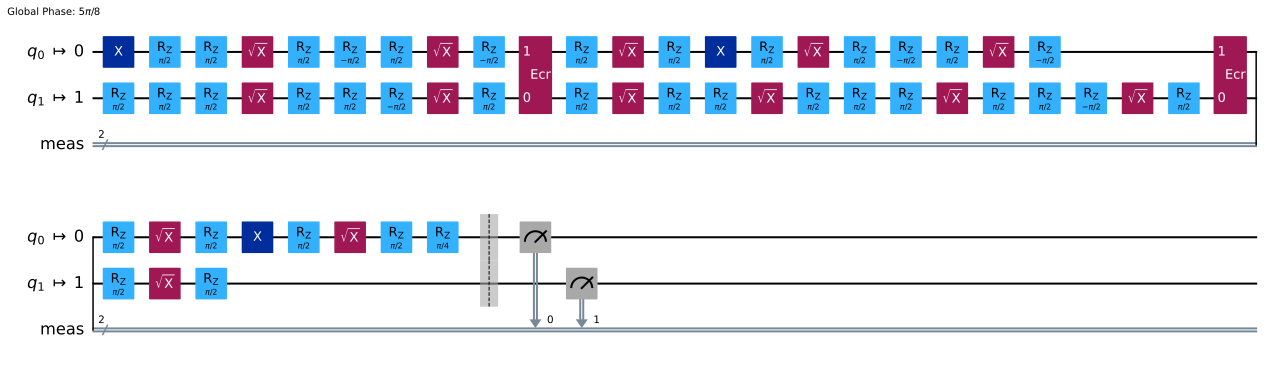

In [262]:
# Create a new circuit with two qubits
q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")
qc = QuantumCircuit(q, c)
qc.x(q[0])
qc.s([q[1],q[0]])
qc.h(q[0])
qc.cx(q[0],q[1])
qc.h([q[0],q[1]])
qc.cx(q[0],q[1])
qc.h(q[0])
qc.t(q[0])

qc.measure_all()
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")


trans_o3 = transpile(qc, backend=backend, optimization_level=3)
trans_o3.draw("mpl", idle_wires=False)


trans_o2 = transpile(qc, backend=backend, optimization_level=2)
trans_o2.draw("mpl", idle_wires=False)


trans_o1 = transpile(qc, backend=backend, optimization_level=1)
trans_o1.draw("mpl", idle_wires=False)


trans_o0 = transpile(qc,backend=backend, optimization_level=0)
trans_o0.draw("mpl", idle_wires=False)



# Problem of Custom gates
When converting the circuit to QASM String, the string involves custom gates definitions which can be replaced to help the ZXCalc Qasm Parser to work.

Things to improve:

* Some things are manually declared like param0 - so, a solution to deal with custom gates with parameters
* Because I initialized param0=pi/4 this would not be accurate as the value might not always be pi/4

In [263]:
import qiskit.qasm2 as qasm
import pyzx as zx
import re

### FUNCTION FOR A GENERAL APPROACH TO DEAL WITH CUSTOM GATES ###
def replace_custom(trans):
    q1 = qasm.dumps(trans)
    i = q1.find("gate")
    j = q1.find("qreg")
    custom_gates = q1[i:j]
    qstr = q1[:i]+q1[j:] # remove the custom gate
    # print(custom_gates)

    gates = {}
    custom_gates = custom_gates.split("\n")
    # formatting and initializing the dictionary that will hold all the custom gates
    for gate in custom_gates:
        func = gate[gate.find("{"):]
        # make q0, q1 to q[0], q[1]
        func = re.sub("q", "q[", func)
        func = re.sub(r'(q\[\d)', r'\1]', func)
        if gate != "":
            gates[gate[5:8]] = func

    # print("dict:", gates)

    # replace all instances of custom gates in qstr with their respective expanded forms from dict
    for _ in range(0,len(gates)+1):
        
        for g in gates:
            if g in qstr:
                # get index of the entire line from qstr and then replace
                start_index = qstr.find(g)
                next_index = qstr.index(';', start_index)
                qstr = qstr.replace(qstr[start_index:next_index+1],gates[g][2:-1])
                qstr = qstr.replace("param0", "pi/4") # manually declared


    # print(qstr)
    circ1 = zx.qasm(qstr)
    # zx.draw(circ1)
    return circ1


In [264]:
q1 = replace_custom(trans_o1)
q0 = replace_custom(trans_o0)
q2 = replace_custom(trans_o2)
q3 = replace_custom(trans_o3)

In [54]:
verify_eq(q0,q3)

True